# Specviz notebook/GUI interaction on NIRISS WFSS 1D spectra

In environment jdaviz_redshift from rosteen branch on 01/05/2021

Installation instructions:
- Create a fresh conda environment with python (conda create -n env_name python)
- Activate environment (conda activate env_name)
o	Install O’Steen version of jdaviz (because not yet merged into master):
	pip install git+https://github.com/rosteen/jdaviz@redshift_slider#egg=jdaviz
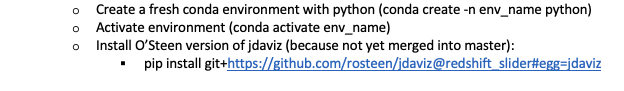

Author: Camilla Pacifici, NIRISS Instrument Scientist

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#plotting and tabling
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,
        'axes.linewidth':2,'animation.html': 'html5',
        'figure.figsize':(8,6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.patches as patches

#import astropy
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.nddata import StdDevUncertainty

#import specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

#import viztools
import jdaviz
from jdaviz import SpecViz

/Users/cpacifici/miniconda3/envs/jdaviz_redshift/lib/python3.8/site-packages/glue/external/echo/__init__.py:3: UserWarning: glue.external.echo is deprecated, import from echo directly instead
  warnings.warn('glue.external.echo is deprecated, import from echo directly instead')


Check versions

In [3]:
print('astropy:',astropy.__version__)
print('specutils:',specutils.__version__)
print('jdaviz:',jdaviz.__version__)

astropy: 4.2
specutils: 1.1
jdaviz: 0.1.dev1258+g6ee99bc


## 1. Load NIRISS pipeline output
We work with the x1d file which contains all extracted 1D spectra.
I want to do this with three filters! (But I only have F150W for now)

In [4]:
filelink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/specviz_notebook_gui_interaction/basic_F150W_WFSSR_dit1_x1d.fits'
hdu = fits.open(filelink)

hdu.info()

Filename: /Users/cpacifici/.astropy/cache/download/url/33545d5dbd50d26d5a9838f2d2259699/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     259   ()      
  1  EXTRACT1D     1 BinTableHDU     47   3R x 9C   [D, D, D, D, D, J, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     47   19R x 9C   [D, D, D, D, D, J, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     47   78R x 9C   [D, D, D, D, D, J, D, D, D]   
  4  EXTRACT1D     4 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
  5  EXTRACT1D     5 BinTableHDU     47   110R x 9C   [D, D, D, D, D, J, D, D, D]   
  6  EXTRACT1D     6 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
  7  EXTRACT1D     7 BinTableHDU     47   105R x 9C   [D, D, D, D, D, J, D, D, D]   
  8  EXTRACT1D     8 BinTableHDU     47   112R x 9C   [D, D, D, D, D, J, D, D, D]   
  9  EXTRACT1D     9 BinTableHDU     47   107R x 9C   [D, D, D, D, D, J, D, D, D]   
 10  EXTRACT1D    10 BinTable

## 2. Open Specviz and load all the 1D spectra
Parsers are not ready for all instruments, so we load the spectrum manually and we write in a Spectrum1D.

**Developer note:**

We need a parser for NIRISS WFSS x1d.fits files.

In [5]:
viz = SpecViz()
viz.app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

In [6]:
for i in range (2,18):
    spec_load = hdu[i+1].data

    #invert axis
    wave = spec_load['WAVELENGTH']
    flux = spec_load['FLUX']
    error = spec_load['ERROR']
    invwave = wave[::-1]
    invflux = flux[::-1]
    inverror = error[::-1]

    #mask the parts where the sensitivity in the bandpass is poor
    mask = ((invwave>1.34) & (invwave<1.66))

    spec1d = Spectrum1D(spectral_axis=invwave[mask]*u.um, 
                    flux=invflux[mask]*u.Jy, 
                    uncertainty=StdDevUncertainty(inverror[mask]*u.Jy)) #
    
    viz.load_spectrum(spec1d,"NIRISS 1D {}".format(str(i+1)))

    #print(spec1d)

This is just for quick look to see all the spectra that are in the file. We find our favorite spectrum and work with that.

### I select the emission lines by hand in the GUI to create subset 1

Instructions: https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#defining-spectral-regions

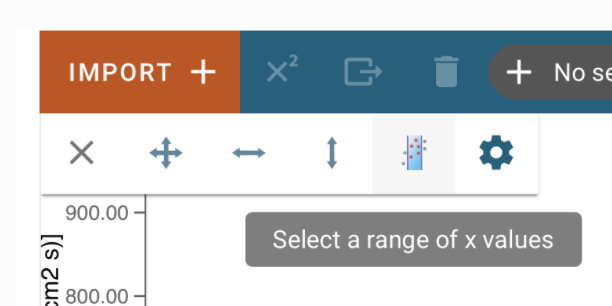

### See what data is used in this specviz istance

In [7]:
dataout = viz.app.get_data_from_viewer("spectrum-viewer")
spec1d_line = dataout["NIRISS 1D 6"]

In [8]:
print(spec1d_line)

Spectrum1D (length=69)
flux:             [ 1.17e-06 Jy, ..., 1.3069e-06 Jy ],  mean=1.4173e-06 Jy
spectral axis:    [ 1.3402 um, ..., 1.6585 um ],  mean=1.4994 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]


**Developer note:**

This is a workaround while waiting for a specutils PR to be merged. https://github.com/astropy/specutils/pull/722

### See how the subsets are defined

In [9]:
region = viz.get_spectral_regions()
region['Subset 1']

Spectral Region, 1 sub-regions:
  (1.3429096820852529 um, 1.434134673755561 um) 

## Now I can do the same thing in coding
I can define my own region (cont_region) between arbitrary bounds. I choose 1.35um and 1.42um.

In [10]:
cont_region = SpectralRegion(1.35*u.um,1.42*u.um)
spec1d_el_hand = extract_region(spec1d_line, cont_region)
print(spec1d_el_hand)

Spectrum1D (length=15)
flux:             [ 1.6059e-06 Jy, ..., 1.3176e-06 Jy ],  mean=2.4411e-06 Jy
spectral axis:    [ 1.3543 um, ..., 1.4198 um ],  mean=1.387 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]


Or I can use the region I defined by hand in the GUI (region['Subset 1']).

In [11]:
spec1d_el_viz = extract_region(spec1d_line, region['Subset 1'])
print(spec1d_el_viz)

Spectrum1D (length=20)
flux:             [ 1.2888e-06 Jy, ..., 9.304e-07 Jy ],  mean=2.131e-06 Jy
spectral axis:    [ 1.3449 um, ..., 1.4338 um ],  mean=1.3894 um
uncertainty:      [ StdDevUncertainty(0.), ..., StdDevUncertainty(0.) ]


### I can plot the spectrum and the subset with matplotlib

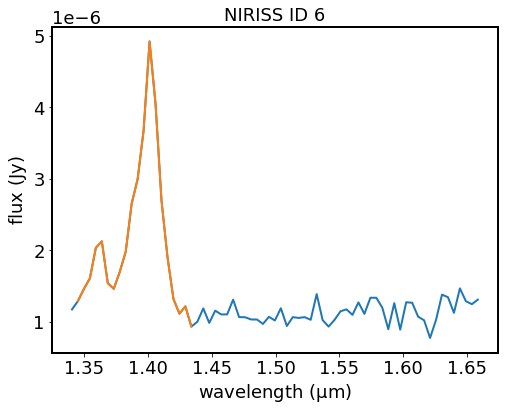

In [12]:
plt.plot(spec1d_line.spectral_axis,spec1d_line.flux)
plt.plot(spec1d_el_viz.spectral_axis,spec1d_el_viz.flux)

plt.xlabel("wavelength ({:latex})".format(spec1d_line.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_line.flux.unit))
plt.title("NIRISS ID 6")
plt.show()


## 4. Use the redshift slider in Specviz to find the redshift

I start by opening a new instance of Specviz.

In [13]:
viz2 = SpecViz()
viz2.app

Application(components={'g-viewer-tab': '<template>\n  <component :is="stack.container">\n    <g-viewer-tab\n …

And I load just the interesting spectrum (spec1d_line).

In [14]:
viz2.load_spectrum(spec1d_line,"NIRISS 1D lines")

I can use an available line lists or define my own lines (I know I need Hb4861.3 and the [OIII]4958.9,5006.8 doublet) and play with the redshift slider to match the lines in the line list with the lines in the spectrum.

Here is the documentation where line lists are explained: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-lists

Now I can move the lines using the redshift slider at the top. It is best to first set the redshift to 2 in the box with the number and then move the slider to bring the lines on top of the observed emission lines.

### Get the redshift out in the Spectrum1D object

In [15]:
spec1d_redshift_out = viz2.app.get_data_from_viewer("spectrum-viewer")["NIRISS 1D lines"]
spec1d_redshift = Spectrum1D(spec1d_redshift_out, redshift=viz2._redshift)

## 5. Use specutils to combine the 3 filters for all spectra

I have not created the simulations in the other two filters yet.